## Module Imports

In [1]:
# pandas for data loading, manipulation etc.
import pandas as pd

# numeric functions
import numpy as np
from scipy import stats
from math import ceil

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modelling
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBRegressor

## Load Data

In [2]:
# Load the data
df_train = pd.read_csv('train.csv',index_col='Id')
df_test = pd.read_csv('test.csv',index_col='Id')

# ids of full training dataset
id_train = df_train.index    

# ids of full test dataset
id_test = df_test.index

# combine train and test datas in to one dataframe
df_all = pd.concat([df_train,df_test])
df_all.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


## Columns with NaN Values

In [3]:
# summary of columns with nan values
#SalePrice nans: test data

cols_with_na = df_all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64


## Meaningful NaN Values

In [4]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_all[col].fillna('None',inplace=True)
    
#GarageYrBlt nans: no garage. Fill with property YearBuilt.
#(more appropriate than 0, which would be ~2000 away from all other values)
df_all.loc[df_all.GarageYrBlt.isnull(),'GarageYrBlt'] = df_all.loc[df_all.GarageYrBlt.isnull(),'YearBuilt']

#No masonry veneer - fill area with 0
df_all.MasVnrArea.fillna(0,inplace=True)

#No basement - fill areas/counts with 0    
df_all.BsmtFullBath.fillna(0,inplace=True)
df_all.BsmtHalfBath.fillna(0,inplace=True)
df_all.BsmtFinSF1.fillna(0,inplace=True)
df_all.BsmtFinSF2.fillna(0,inplace=True)
df_all.BsmtUnfSF.fillna(0,inplace=True)
df_all.TotalBsmtSF.fillna(0,inplace=True)

#No garage - fill areas/counts with 0
df_all.GarageArea.fillna(0,inplace=True)
df_all.GarageCars.fillna(0,inplace=True)

df_all[cols_fillna].head(5)

,PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu,GarageQual,GarageCond,GarageFinish,GarageType,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType1,BsmtFinType2
Id,,,,,,,,,,,,,,,
1,None,None,None,None,BrkFace,None,TA,TA,RFn,Attchd,No,TA,Gd,GLQ,Unf
2,None,None,None,None,None,TA,TA,TA,RFn,Attchd,Gd,TA,Gd,ALQ,Unf
3,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Mn,TA,Gd,GLQ,Unf
4,None,None,None,None,None,Gd,TA,TA,Unf,Detchd,No,Gd,TA,ALQ,Unf
5,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Av,TA,Gd,GLQ,Unf


## LotFrontage NaN Values

In [5]:
# function to normalise a column of values to lie between 0 and 1
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

----------------
Intercept: 93.208483254
----------------
LotArea             71.475879
RoofMatl_ClyTile    49.396968
1stFlrSF            27.547832
PoolArea            26.905146
RoofStyle_Shed      25.874524
GrLivArea           22.148975
Foundation_Wood     20.075497
LotShape_IR3        17.721471
GarageArea          17.536239
BldgType_2fmCon     16.123235
dtype: float64
----------------
Utilities_AllPub      -11.610027
BldgType_TwnhsE       -12.070870
BsmtCond_Po           -12.151678
Exterior1st_CemntBd   -14.553347
PoolQC_Fa             -14.706527
RoofMatl_WdShake      -15.579127
BldgType_Twnhs        -17.924473
RoofMatl_WdShngl      -18.222015
GarageYrBlt           -21.591319
LotConfig_CulDSac     -23.428742
dtype: float64
----------------
R2: 0.688922936177
----------------


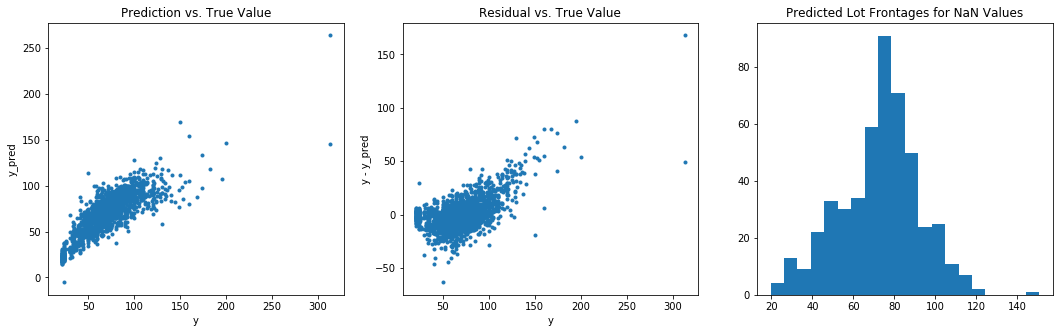

In [6]:
#LotFrontage
# fill nan values using a linear regressor

# convert categoricals to dummies, exclude SalePrice from model
df_frontage = pd.get_dummies(df_all.drop('SalePrice',axis=1))

# normalise columns to 0-1
for col in df_frontage.drop('LotFrontage',axis=1).columns:
    df_frontage[col] = scale_minmax(df_frontage[col])

lf_train = df_frontage.dropna()
lf_train_y = lf_train.LotFrontage
lf_train_X = lf_train.drop('LotFrontage',axis=1)  

# fit model
lr = Ridge()
lr.fit(lf_train_X, lf_train_y)

# check model results
lr_coefs = pd.Series(lr.coef_,index=lf_train_X.columns)

print('----------------')
print('Intercept:',lr.intercept_)
print('----------------')
print(lr_coefs.sort_values(ascending=False).head(10))
print('----------------')
print(lr_coefs.sort_values(ascending=False).tail(10))
print('----------------')
print('R2:',lr.score(lf_train_X,lf_train_y))
print('----------------')

lf_pred_y = lr.predict(lf_train_X)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(lf_train_y,lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y_pred');
plt.title('Prediction vs. True Value')

plt.subplot(1,3,2)
plt.plot(lf_train_y, lf_train_y-lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('Residual vs. True Value')


# fill na values using model predictions
nan_frontage = df_all.LotFrontage.isnull()
X = df_frontage[nan_frontage].drop('LotFrontage',axis=1)
y = lr.predict(X)

plt.subplot(1,3,3)
plt.hist(y,bins=20)
plt.title('Predicted Lot Frontages for NaN Values')

# fill nan values
df_all.loc[nan_frontage,'LotFrontage'] = y

## Remaining NaNs

In [7]:
# Remaining Nan values
cols_with_na = df_all.drop('SalePrice',axis=1).isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]

print(cols_with_na.sort_values(ascending=False))

rows_with_na = df_all.drop('SalePrice',axis=1).isnull().sum(axis=1)
rows_with_na = rows_with_na[rows_with_na>0]
print(rows_with_na.sort_values(ascending=False))

# fill remaining nans with mode in that column
for col in cols_with_na.index:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)

MSZoning       4
Utilities      2
Functional     2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
Electrical     1
dtype: int64
Id
2217    2
2152    2
1916    2
2905    1
2490    1
2474    1
2251    1
1946    1
1556    1
1380    1
dtype: int64


In [8]:
# Now no more NaN values apart from SalePrice in test data
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      29

## Distribution of SalePrice

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


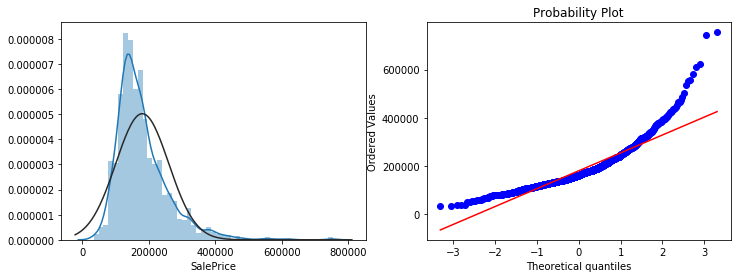

In [9]:
print(df_all.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(df_all.SalePrice.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(df_all.SalePrice.dropna(), plot=plt)

## Log Transform SalePrice

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64


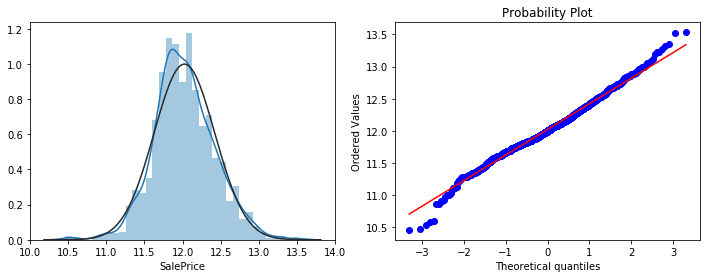

In [10]:
#Log Transform SalePrice to improve normality
sp = df_all.SalePrice
df_all.SalePrice = np.log1p(sp)

print(df_all.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(sp.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(sp.dropna(), plot=plt)

## Basement Finish Types

,BsmtGLQ,BsmtALQ,BsmtBLQ,BsmtRec,BsmtLwQ,BsmtUnf
Id,,,,,,
1,0.824766,0.000000,0.0,0.0,0.0,0.175234
2,0.000000,0.774960,0.0,0.0,0.0,0.225040
3,0.528261,0.000000,0.0,0.0,0.0,0.471739
4,0.000000,0.285714,0.0,0.0,0.0,0.714286
5,0.572052,0.000000,0.0,0.0,0.0,0.427948


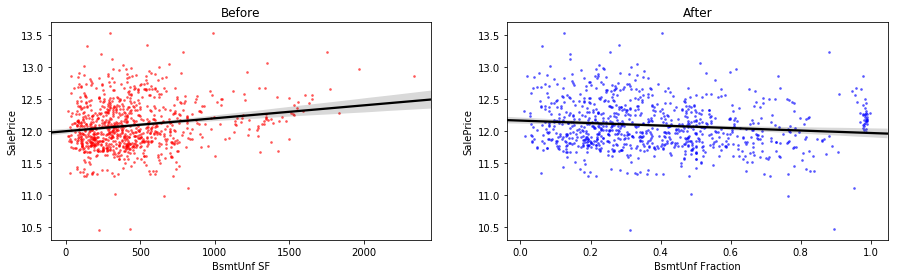

In [11]:
# create separate columns for area of each possible
# basement finish type
bsmt_fin_cols = ['BsmtGLQ','BsmtALQ','BsmtBLQ',
                 'BsmtRec','BsmtLwQ','BsmtUnf']

for col in bsmt_fin_cols:
    # initialise as columns of zeros
    df_all[col] = 0

# assign old UnfSF column to the new one
df_all['BsmtUnf'] = df_all['BsmtUnfSF']

# fill remaining finish type columns
for row in df_all.index:
    fin1 = df_all.loc[row,'BsmtFinType1']
    if (fin1!='None') and (fin1!='Unf'):
        # add area (SF) to appropriate column
        df_all.loc[row,'Bsmt'+fin1] += df_all.loc[row,'BsmtFinSF1']
        
    fin2 = df_all.loc[row,'BsmtFinType2']
    if (fin2!='None') and (fin2!='Unf'):
        df_all.loc[row,'Bsmt'+fin2] += df_all.loc[row,'BsmtFinSF2']

# normalise new columns by TotalBsmtSF
for col in bsmt_fin_cols:
    df_all.loc[df_all['TotalBsmtSF']>0, col] = df_all.loc[df_all['TotalBsmtSF']>0,col] / df_all['TotalBsmtSF'] 

#plot to demonstrate the effect of the new feature
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.regplot(df_all.loc[(df_all['BsmtUnf']>0) & (df_all['BsmtUnf']<1), 'BsmtUnfSF'],
            df_all.loc[(df_all['BsmtUnf']>0) & (df_all['BsmtUnf']<1), 'SalePrice'],
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'r'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf SF')
plt.title('Before')

plt.subplot(1,2,2)
sns.regplot(df_all.loc[(df_all['BsmtUnf']>0) & (df_all['BsmtUnf']<1), 'BsmtUnf'],
            df_all.loc[(df_all['BsmtUnf']>0) & (df_all['BsmtUnf']<1), 'SalePrice'],            
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'b'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf Fraction')
plt.title('After')

# remove initial BsmtFin columns
df_all.drop(['BsmtFinType1','BsmtFinSF1','BsmtFinType2',
             'BsmtFinSF2','BsmtUnfSF'], axis=1, inplace=True)

df_all[bsmt_fin_cols].head(5)



## 1st and 2nd Floor Area

In [ ]:
df_all['LowQualFin'] = df_all['LowQualFinSF']/df_all['GrLivArea']
df_all['1stFlr'] = df_all['1stFlrSF']/df_all['GrLivArea']
df_all['2ndFlr'] = df_all['2ndFlrSF']/df_all['GrLivArea']

df_all.drop(['LowQualFinSF','1stFlrSF','2ndFlrSF'],axis=1,inplace=True)

## Distribution of SalePrice in Categorical Variables

In [ ]:
# MSubClass should be treated as categorical
df_all['MSSubClass'] = df_all['MSSubClass'].astype(object)

# Extract categorical column names (have type object)
cols_categ = df_all.dtypes[df_all.dtypes == object].index.tolist()

# plot categorical variables
fcols = 3
frows = ceil(len(cols_categ)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_categ):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

In [ ]:
# few bigger plots for features with two many categories to see above

#Neighbourhood
plt.figure(figsize=(25,5))
sns.violinplot(x='Neighborhood',y='SalePrice',data=df_all)
plt.xticks(rotation=45);

#Exterior1st
plt.figure(figsize=(25,5))
sns.violinplot(x='Exterior1st',y='SalePrice',data=df_all)
plt.xticks(rotation=45);

## Significance of Categorical Features for SalePrice

In [ ]:
# anova test to check significance of variation between groups
def anova(group,value):
    # select columns of interest, and remove any rows with nan values
    data = df_all[[group,value]]
    data = data[~(data[group].isnull() | data[value].isnull())]
    
    # stats across all data
    tot_groups = data[group].nunique() # no. of groups
    len_data = len(data) # total sample size of house (all groups)
    mean_data = data[value].mean() # mean across all groups
    df_betwn = tot_groups - 1 # degrees of freedom betwn grps
    df_within = len_data - tot_groups # degrees of freedom within grps
    
    # per group stats
    n_in_group = data.groupby(group)[value].count() # no. houses in group
    mean_group = data.groupby(group)[value].mean() # mean value in this group
    
    # between-group variability
    betwn_var = n_in_group*((mean_group - mean_data)**2)
    betwn_var = float(betwn_var.sum())/df_betwn
    
    # within-group variability
    within_var = 0
    for grp in data[group].unique():
        samples = data.loc[data[group]==grp, value]
        within_var += ((samples-mean_group[grp])**2).sum()
        
    within_var = float(within_var)/df_within
    
    #F-test statistic
    F = betwn_var/within_var
    
    # p-value
    p = stats.f.sf(F, df_betwn, df_within)
    
    return p
        

In [ ]:
# check significance of categorical variables on SalePrice
p_col = dict()

for col in cols_categ:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

## Categorical Features with Meaningful Ordering

In [ ]:
# convert some categorical values to numeric scales

#Excellent, Good, Typical, Fair, Poor, None: Convert to 0-5 scale
cols_ExGd = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_ExGd:
    df_all[col].replace(dict_ExGd, inplace=True)

display(df_all[cols_ExGd].head(5))    

# Remaining columns
df_all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)

df_all['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

df_all['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)

df_all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)

df_all['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

df_all['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)

df_all['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)

## Encoding Remaining Categoricals

In [ ]:
# Remaining categorical columns

# MSubClass should be treated as categorical
df_all['MSSubClass'] = df_all['MSSubClass'].astype(object)

cols_categ = df_all.dtypes[df_all.dtypes == object].index.tolist()

print(len(cols_categ),'remaining categorical columns:\n',cols_categ)

In [ ]:
# replace strings with mean SalePrice for that category value
for col in cols_categ:
    encoding = df_all.groupby(col).SalePrice.mean()
    df_all[col].replace(encoding,inplace=True)
    
df_all[cols_categ].head(5)

## Dealing with Zeros

In [ ]:
# fraction of zeros in each column
frac_zeros = ((df_all==0).sum()/len(df_all))

# no. unique values in each column
n_unique = df_all.nunique()

# difference between frac. zeros and expected
# frac. zeros if values evenly distributed between
# classes
xs_zeros = frac_zeros - 1/n_unique

# create dataframe and display which columns may be problematic
zero_cols = pd.DataFrame({'frac_zeros':frac_zeros,'n_unique':n_unique,'xs_zeros':xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='xs_zeros',ascending=False,inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])

#very few properties with Pool or 3SsnPorch
#replace columns with binary indicator
df_all['Pool'] = (df_all['PoolArea']>0).astype(int)
df_all['3SsnPorch'] = (df_all['3SsnPorch']>0).astype(int)
df_all.drop(['PoolQC','PoolArea','3SsnPorch'],axis=1,inplace=True)

# 'half' bathrooms - add half value to 'full' bathrooms
df_all['BsmtFullBath'] = df_all['BsmtFullBath'] + 0.5*df_all['BsmtHalfBath']
df_all['FullBath'] = df_all['FullBath'] + 0.5*df_all['HalfBath']
df_all.drop(['BsmtHalfBath','HalfBath'],axis=1,inplace=True)

# create additional dummy variable for
# continuous variables with a lot of zeros
dummy_cols = ['LowQualFin','2ndFlr',
              'MiscVal','ScreenPorch','WoodDeckSF','OpenPorchSF',
              'EnclosedPorch','MasVnrArea','GarageArea','Fireplaces',             
              'BsmtGLQ','BsmtALQ','BsmtBLQ','BsmtRec',
              'BsmtLwQ','BsmtUnf','TotalBsmtSF']

for col in dummy_cols:
    df_all['Has'+col] = (df_all[col]>0).astype(int)

In [ ]:
#PROBLEM OF LOTS OF ZEROS -2ndFlrSF
#####
# mode only using 2ndflrsf
#####
tmp = scale_minmax(df_all[['SalePrice','2ndFlr','Has2ndFlr']].dropna())

y = tmp.SalePrice
X = tmp['2ndFlr']

plt.plot(X,y,'.',label='data',alpha=0.5)

lr = LinearRegression()
lr.fit(X.values.reshape(-1, 1),y)
lr_coefs = pd.Series(lr.coef_,index=['Has2ndFlr'])
lr_intercept = lr.intercept_

def regval(flr2ndSF):
    return flr2ndSF*lr_coefs + lr_intercept

plt.plot([0,1],[regval(0),regval(1)],'b',linewidth=3,label='2ndFlr only')

#####
# model using has2ndflr dummy variable
#####
tmp = scale_minmax(df_all[['SalePrice','2ndFlr','Has2ndFlr']].dropna())

y = tmp.SalePrice

X = tmp.drop('SalePrice',axis=1)

lr = LinearRegression()
lr.fit(X,y)
lr_coefs = pd.Series(lr.coef_,index=X.columns)
lr_intercept = lr.intercept_

def regval(flr2ndSF,has2nd):
    return flr2ndSF*lr_coefs['2ndFlr'] + has2nd*lr_coefs['Has2ndFlr'] + lr_intercept

plt.plot([0,0.02,1],[regval(0,0),regval(0,1),regval(1,1)],'r',linewidth=3,label='with Has2ndFlr')

plt.legend()
plt.xlabel('2ndFlr')
plt.ylabel('SalePrice');

## Identify Types of Features

In [ ]:
# choose any numeric column with less than 13 unique values to be
# "discrete", other columns "continuous"
# 13 chosen so months of the year are "discrete"
col_nunique = df_all.nunique()

cols_discrete = col_nunique[col_nunique<13].index.tolist()
cols_continuous = col_nunique[col_nunique>=13].index.tolist()

print(len(cols_continuous),'continuous columns, and',
      len(cols_discrete),'discrete columns.')

## Distribution of Continuous Variables and Effect on SalePrice

In [ ]:
# plot numeric values

fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(5*fcols,4*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='SalePrice', data=df_all, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(df_all[col].dropna() , fit=stats.norm)
    plt.xlabel(col)

## Distribution of Discrete Variables and Effect on SalePrice

In [ ]:
# numeric columns with few values
fcols = 3
frows = ceil(len(cols_discrete)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_discrete):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

## Significance of Discrete Numeric Features for SalePrice

In [ ]:
p_col = dict()

for col in cols_discrete:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

## Correlation Between Numeric Features

In [ ]:
# correlation between numeric variables
df_corr = df_all.loc[id_train].corr(method='spearman').abs()

# order columns and rows by correlation with SalePrice
df_corr = df_corr.sort_values('SalePrice',axis=0,ascending=False).sort_values('SalePrice',axis=1,ascending=False)

print(df_corr.SalePrice.head(20))
print('-----------------')
print(df_corr.SalePrice.tail(10))

ax=plt.figure(figsize=(25,20)).gca()
sns.heatmap(df_corr,ax=ax,square=True);

## Collinearity

Many variables strongly correlated, e.g. GarageCars and GarageArea (below).

Kept all features, but feature selection/pca may help some models.

In [ ]:
sns.regplot(x='GarageCars',y='GarageArea',data=df_all)

## Normalise Features

In [ ]:
# normalise numeric columns
scale_cols = [col for col in df_all.columns if col!='SalePrice']

df_all = df_all.apply(scale_minmax,axis=0)

df_all.describe()

## Which Features are Candidates to be Transformed?

In [ ]:
#Check effect of Box-Cox transforms on distributions of continuous variables
fcols = 6
frows = len(cols_continuous)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_continuous:
    if var!='SalePrice':
        dat = df_all[[var, 'SalePrice']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['SalePrice'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['SalePrice'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['SalePrice'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['SalePrice'])[0][1]))

## Box-Cox Transform Suitable Variables

In [ ]:
# variables not suitable for box-cox transformation based on above (usually due to excessive zeros)
# NB - have tried BoxCox on SalePrice, but no improvement or slightly worse
# than log transform. Kept log transform to make it simpler to restore SalePrice predictions.
cols_notransform = ['1stFlr','2ndFlr','3SsnPorch','EnclosedPorch',
                    'LowQualFin','MasVnrArea','MiscVal','PoolArea',
                    'ScreenPorch','OpenPorchSF','WoodDeckSF','SalePrice',
                    'BsmtGLQ','BsmtALQ','BsmtBLQ','BsmtRec','BsmtLwQ','BsmtUnf']

cols_transform = [col for col in cols_continuous if col not in cols_notransform]

#transform remaining variables
print('Transforming',len(cols_transform),'columns:',cols_transform)

for col in cols_transform:   
    # transform column
    df_all.loc[:,col], _ = stats.boxcox(df_all.loc[:,col]+1)
    
    # renormalise column
    df_all.loc[:,col] = scale_minmax(df_all.loc[:,col])

## Prepare Data for Model Fitting

In [ ]:
# select features, encode categoricals, create dataframe for model fitting

# select which features to use (all for now)
model_cols = df_all.columns

# encode categoricals
df_model = df_all[model_cols]
        
display(df_model.head())

## Identify and Remove Outliers

In [ ]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
# function to detect outliers based on the predictions of a model
def remove_outliers(model, X, y, sigma=3, drop=True, verbose=False):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>3].index
    
    # print and plot the results if asked
    if verbose:
        print('R2=',model.score(X,y))
        print('rmse=',rmse(y, y_pred))
        print('---------------------------------------')

        print('mean of residuals:',mean_resid)
        print('std of residuals:',std_resid)
        print('---------------------------------------')
        
        print(len(outliers),'outliers:')
        print(outliers.tolist())
        
        plt.figure(figsize=(15,5))
        ax_131 = plt.subplot(1,3,1)
        plt.plot(y,y_pred,'.')
        plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
        plt.legend(['Accepted','Outlier'])
        plt.xlabel('y')
        plt.ylabel('y_pred');

        ax_132=plt.subplot(1,3,2)
        plt.plot(y,y-y_pred,'.')
        plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
        plt.legend(['Accepted','Outlier'])
        plt.xlabel('y')
        plt.ylabel('y - y_pred');

        ax_133=plt.subplot(1,3,3)
        z.plot.hist(bins=50,ax=ax_133)
        z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
        plt.legend(['Accepted','Outlier'])
        plt.xlabel('z')

    # remove outliers from data if requested
    if drop:
        X = X.drop(outliers)
        y = y.drop(outliers)

    return X,y,outliers

In [ ]:
# function to get training samples
def get_training_data():
    # extract training samples
    df_train = df_model.loc[id_train]
    
    # split SalePrice and features
    y = df_train.SalePrice
    X = df_train.drop('SalePrice',axis=1)
    
    return X, y

# extract test data (without SalePrice)
def get_test_data():
    return df_model.loc[id_test].drop('SalePrice',axis=1)

In [ ]:
# get training data
X, y = get_training_data()

# find and remove outliers using a Ridge model
X,y,outliers = remove_outliers(Ridge(), X, y, verbose=True)

## First Model - LinearRegression with Regularisation (Ridge)

0.1207 on leaderboard

In [ ]:
# basic linear model
lr = Ridge()
lr.fit(X,y)
lr_coefs = pd.Series(lr.coef_,index=X.columns)

print('---------------------------------------')
print('Top 20 contributers to increased price:')
print('---------------------------------------')
print(lr_coefs.sort_values(ascending=False).head(20))
print('---------------------------------------')
print('Top 20 contributers to decreased price:')
print('---------------------------------------')
print(lr_coefs.sort_values(ascending=True).head(20))
print('---------------------------------------')
print('Intercept: ',lr.intercept_)
print('---------------------------------------')

y_pred = lr.predict(X)
rms_pred = rmse(y, y_pred)

print('R2=',lr.score(X,y))
print('rmse=',rms_pred)
rkfold = RepeatedKFold(n_splits=5, n_repeats=10)
print('cross_val',
      abs(np.mean(cross_val_score(lr, X, y, 
                                  scoring=rmse_scorer, 
                                  cv=rkfold))))
print('---------------------------------------')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y,y_pred,'.')
plt.xlabel('y')
plt.ylabel('y_pred');

plt.subplot(1,2,2)
plt.plot(y,y-y_pred,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');

## Optimise Model Parameters

In [ ]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    # get unmodified training data, unless data to use already specified
    if len(y)==0:
        X,y = get_training_data()
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring=rmse_scorer,
                               verbose=1, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract results and best model from the grid
        grid_results = pd.DataFrame(gsearch.cv_results_)
        model = gsearch.best_estimator_
    else:
        grid_results = []
        
    # re-fit the model with the same parameters, but excluding outliers
    X,y,outliers = remove_outliers(model, X, y)
    model.fit(X,y)

    cv_score = cross_val_score(model, X, y, scoring=rmse_scorer, cv=rkfold)
    cv_mean = abs(np.mean(cv_score))
    cv_std = np.std(cv_score)
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, model.predict(X)))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(model.predict(X),index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

In [ ]:
# dict to store optimal models
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5

## Linear Regression

### Ridge

In [ ]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

### Lasso

In [ ]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

### ElasticNet

In [ ]:
model ='ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {'alpha': np.arange(0.1,1.1,0.1),
              'l1_ratio': np.arange(0.1,1.0,0.1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

## SVM

### Linear

In [ ]:
model='LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1,1.0,0.1)
param_grid = {'C':crange}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(crange, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score');

### Non-Linear

In [ ]:
model ='SVR'
opt_models[model] = SVR()

param_grid = {'C':np.arange(1,21,2),
              'kernel':['poly','rbf','sigmoid']}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

## KNeighbors

In [ ]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(np.arange(3,11,1), abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('n_neighbors')
plt.ylabel('score');

## Tree-Based

### Random Forest

In [ ]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[25,50,75],
              'min_samples_split':[2,4,6]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

### Gradient Boosting

In [ ]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[100,175,250],
              'max_depth':[2,3,4],
              'min_samples_split':[5,6,7]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

### XGBoost

In [ ]:
model = 'XGB'
opt_models[model] = XGBRegressor()

param_grid = {'n_estimators':[100,200,300,400,500],
              'max_depth':[1,2,3],
             }

opt_models[model], cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

## PCA then Ridge with 2nd Order Terms

In [ ]:
model = 'PolyPCA'

X,y=get_training_data()

# get 2nd order terms
poly = PolynomialFeatures()
X = poly.fit_transform(X,y)

# reduce dimensionality using PCA
# n_components = len(X) by default
# (as no. polynomial features >> len(x))
pca = PCA()
X = pca.fit_transform(X,y)
X = pd.DataFrame(X,index=y.index)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no. components')
plt.ylabel('cumulative explained variance ratio')
plt.title('PCA result')

alph_range = np.arange(5,100,5)
param_grid = {'alpha':alph_range}
ridge, cv_score, grid_results = train_model(Ridge(),X=X,y=y,param_grid=param_grid)

cv_score.name = model
score_models = score_models.append(cv_score)

# combine results in to a pipeline
opt_models[model] = Pipeline([('Poly',poly),('PCA',pca),('Ridge',ridge)])

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

## Compare Models

In [ ]:
X,y = get_training_data()

Y_models = pd.DataFrame(index=y.index)    

for key, model in opt_models.items():
    Y_models[key] = model.predict(X)

corr_models = pd.DataFrame(Y_models).corr()

score_models = score_models.sort_values(by='mean')

display(score_models)
score_models['mean'].plot.barh()
plt.xlabel('score')

plt.figure()
display(corr_models)
sns.heatmap(corr_models)

## Predict SalePrice for the Test Data

In [ ]:
def predict_test(model):
    # get test data
    X_test = get_test_data()

    # predict SalePrices
    y_test = model.predict(X_test)

    #revert log transformation
    y_test = np.exp(y_test)-1

    y_test = pd.DataFrame(y_test,index=X_test.index)
    y_test.columns = ['SalePrice']
    
    return y_test

In [ ]:
y_test = predict_test(opt_models['Lasso'])

y_test.plot.hist(bins=20)

# make submission file
y_test.to_csv('submission.csv')

### Ensemble Model

Not found an approach that gives a score improvement over just Lasso.

In [ ]:
# weights to try in an ensemble model:
# 1/score^2 normalised to sum to 1
def model_weights(models):
    weights = 1/(score_models.loc[models,'mean']**2)
    weights = weights/sum(weights)
    return weights

# predict a SalePrice using multiple models
def predict_ensemble(models):
    # get test data
    X_test = get_test_data()
   
    # predict SalePrice for each model
    Y_models = pd.DataFrame(index=X_test.index)    
    for model in models:
        Y_models[model] = opt_models[model].predict(X_test)

    # get weights for each model
    weights = model_weights(models)
    
    # calculate final prediction
    Y_models = Y_models*weights
    y_test = Y_models.sum(axis=1)

    #revert log transformation
    y_test = np.exp(y_test)-1
    
    # convert to dataframe suitable for creating submission file
    y_test = pd.DataFrame(y_test,index=X_test.index)
    y_test.columns = ['SalePrice']
    
    return y_test

#example with top 5 models
print(model_weights(score_models.iloc[:5].index))
y_test = predict_ensemble(score_models.iloc[:5].index)
y_test.plot.hist(bins=20)

In [ ]:
#Think about:
# Outlier removal - may be harmful some cases?

In [ ]:
lasso_coefs = pd.Series(opt_models['Lasso'].coef_,index=X.columns).sort_values()
plt.figure(figsize=(10,20))
lasso_coefs[lasso_coefs!=0].plot.barh()
print('------------------------')
print(sum(lasso_coefs==0),'zero coefficients:')
print('------------------------')
print(lasso_coefs[lasso_coefs==0].index.sort_values().tolist())
print('------------------------')
print(sum(lasso_coefs!=0),'non-zero coefficients:')
print('------------------------')

In [ ]:
df_all.SalePrice